<a href="https://colab.research.google.com/github/Dorthi12/Hawkin-s-Farm/blob/dorthi-ml/priceprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded rows: 5000 columns: 7
         sku category     mrp  month        state  units_sold  target_price
0  GRA_00000   grapes  766.56      6      Gujarat          70        455.69
1  GRA_00001   grapes  489.22      2    Telangana          98        334.19
2  ORA_00002   orange  283.88      3  Maharashtra         220        203.11
Train size: (4250, 6) Val size: (750, 6)
[0]	train-mae:219.59677	val-mae:222.33607
[50]	train-mae:21.62684	val-mae:26.91666
[100]	train-mae:18.35950	val-mae:26.43140
[150]	train-mae:16.21461	val-mae:26.27356
[159]	train-mae:15.88678	val-mae:26.33021
Validation MAE: 26.3302
Validation MAPE: 6.12%
Baseline MAE (train mean): 239.3886
Saved pipeline to: /mnt/data/price_model/price_xgb_pipeline.pkl


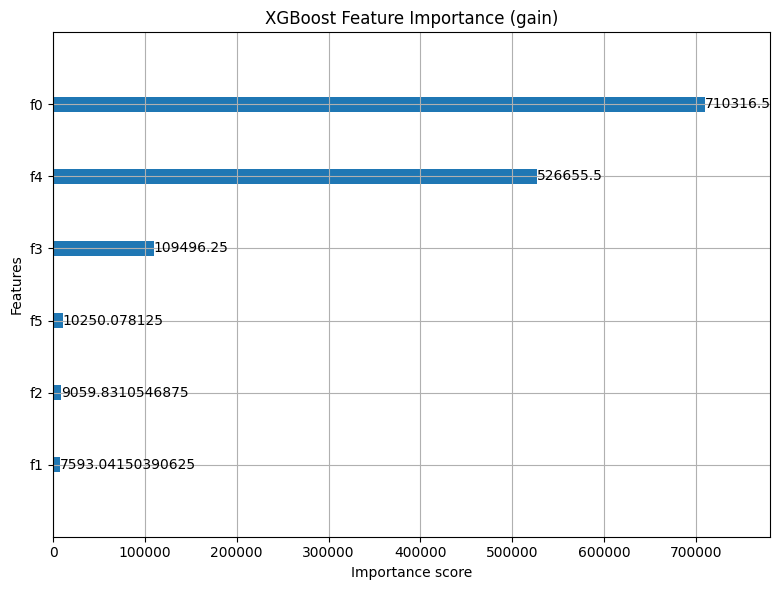

Example suggestion: 325.62701416015625


In [1]:
# Fast & balanced XGBoost price prediction training script
# Adapted for: /mnt/data/pricing_synthetic.csv
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# ------------- Config -------------
CSV_PATH = "/content/pricing_synthetic.csv"
OUT_DIR = Path("/mnt/data/price_model")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
NUM_BOOST_ROUND = 300
EARLY_STOPPING = 30
LEARNING_RATE = 0.1
TEST_SIZE = 0.15

# ------------- Load data -------------
df = pd.read_csv(CSV_PATH)
print("Loaded rows:", len(df), "columns:", df.shape[1])
print(df.head(3))

# ------------- Feature engineering -------------
df["log_mrp"] = np.log1p(df["mrp"])
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

num_cols = ["log_mrp", "units_sold", "mrp"]
cat_cols = ["category", "state"]

# Numeric imputation
num_imp = SimpleImputer(strategy="median")
df[num_cols] = num_imp.fit_transform(df[num_cols])

# Categorical encoding
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df[cat_cols] = enc.fit_transform(df[cat_cols].astype(str))

features = ["log_mrp", "month_sin", "month_cos", "units_sold", "category", "state"]
X = df[features]
y = df["target_price"].astype(float)

# ------------- Train / Validation split -------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print("Train size:", X_train.shape, "Val size:", X_val.shape)

# ------------- XGBoost DMatrix (use numpy to avoid pandas-index warnings) -------------
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dval = xgb.DMatrix(X_val.values, label=y_val.values)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": LEARNING_RATE,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": RANDOM_STATE,
    "verbosity": 0
}

# ------------- Train with early stopping -------------
watchlist = [(dtrain, "train"), (dval, "val")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=watchlist,
    early_stopping_rounds=EARLY_STOPPING,
    verbose_eval=50
)

# ------------- Predict & evaluate -------------
y_pred = bst.predict(dval)
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation MAPE: {mape*100:.2f}%")
# Baseline (predict training mean)
baseline_mae = mean_absolute_error(y_val, [y_train.mean()]*len(y_val))
print(f"Baseline MAE (train mean): {baseline_mae:.4f}")

# ------------- Save model & preprocessors -------------
model_artifact = {
    "xgb_model": bst,
    "num_imputer": num_imp,
    "encoder": enc,
    "features": features
}
joblib.dump(model_artifact, OUT_DIR / "price_xgb_pipeline.pkl")
print("Saved pipeline to:", OUT_DIR / "price_xgb_pipeline.pkl")

# ------------- Feature importance (gain) -------------
plt.figure(figsize=(8,6))
ax = plt.gca()
xgb.plot_importance(bst, importance_type="gain", max_num_features=12, ax=ax)
plt.title("XGBoost Feature Importance (gain)")
plt.tight_layout()
plt.show()

# ------------- Quick inference helper -------------
def suggest_price(sample: dict):
    """
    sample keys must match feature names (mrp, month, units_sold, category, state)
    Example: {"mrp":500, "month":7, "units_sold":120, "category":"rice", "state":"Kerala"}
    """
    s = pd.DataFrame([sample])
    # apply same featurization
    s["log_mrp"] = np.log1p(s["mrp"])
    s["month_sin"] = np.sin(2 * np.pi * s["month"] / 12)
    s["month_cos"] = np.cos(2 * np.pi * s["month"] / 12)
    # impute numeric
    s[num_cols] = num_imp.transform(s[num_cols])
    # encode categorical
    s[cat_cols] = enc.transform(s[cat_cols].astype(str))
    Xs = s[features].values
    d = xgb.DMatrix(Xs)
    return float(bst.predict(d)[0])

# Example usage
print("Example suggestion:", suggest_price({"mrp":500.0, "month":7, "units_sold":120, "category":"rice", "state":"Kerala"}))
